First visualize trajectories with the extended Van der Pol Oszillator.

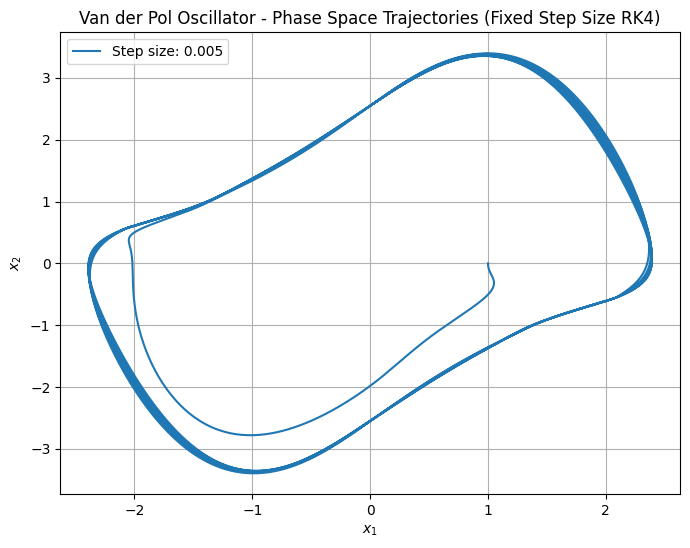

/tmp/ipykernel_242264/2982460267.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

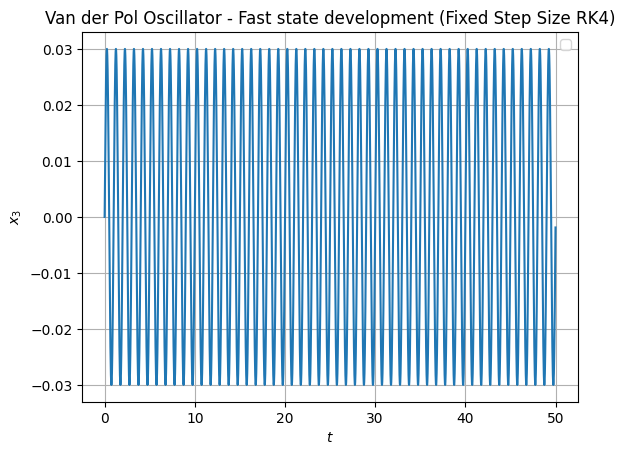

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define system parameters
mu = 1.0
epsilon_1, epsilon_2, epsilon_3, epsilon_4 = 10, 0.3, 5, 0.005
d1, d2, d3 = 0.4, 0.4, 20

# Define periodic control input u
def control_input(t, scale=0.3):
    return scale*np.sin(2 * np.pi * t), scale*np.sin(2 * np.pi * t) # Example: sinusoidal input

# Define the modified Van der Pol oscillator
def van_der_pol(t, X):
    x1, x2, x3 = X
    u_1, u_2 = control_input(t)
    dx1 = x2 + d1 * u_1 + epsilon_1 * x3
    dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + epsilon_3 * x3 + d2 * u_2
    dx3 = - (1 / epsilon_4) * x3 + d3 * u_2
    return np.array([dx1, dx2, dx3])

# Fixed-step RK4 integrator
def rk4_integrate(f, X0, t_span, step_size):
    t_values = np.arange(t_span[0], t_span[1], step_size)
    X_values = np.zeros((len(t_values), len(X0)))
    
    X = np.array(X0)
    for i, t in enumerate(t_values):
        X_values[i] = X
        
        k1 = step_size * f(t, X)
        k2 = step_size * f(t + step_size / 2, X + k1 / 2)
        k3 = step_size * f(t + step_size / 2, X + k2 / 2)
        k4 = step_size * f(t + step_size, X + k3)
        
        X += (k1 + 2 * k2 + 2 * k3 + k4) / 6  # RK4 update rule

    return t_values, X_values

# Initial conditions
X0 = [1.0, 0.0, 0.0]
t_span = (0, 50)  # Time range

# Different step sizes for integration
step_size = 0.005  # Decreasing step sizes, RUKU fails for 0.03

plt.figure(figsize=(8, 6))

# Solve the ODE using RK4 with a fixed step size
t_vals, X_vals = rk4_integrate(van_der_pol, X0, t_span, step_size)

# Extract solutions
x1, x2, x3 = X_vals[:, 0], X_vals[:, 1],  X_vals[:, 2]

# Plot trajectories
plt.plot(x1, x2, label=f"Step size: {step_size}")

# Plot settings
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Van der Pol Oscillator - Phase Space Trajectories (Fixed Step Size RK4)")
plt.legend()
plt.grid()
plt.show()

# Plot the the fast state over time
plt.plot(t_vals, x3)
plt.xlabel("$t$")
plt.ylabel("$x_3$")
plt.title("Van der Pol Oscillator - Fast state development (Fixed Step Size RK4)")
plt.legend()
plt.grid()
plt.show



Next, compare with trajectories obtained when x3 is neglected.

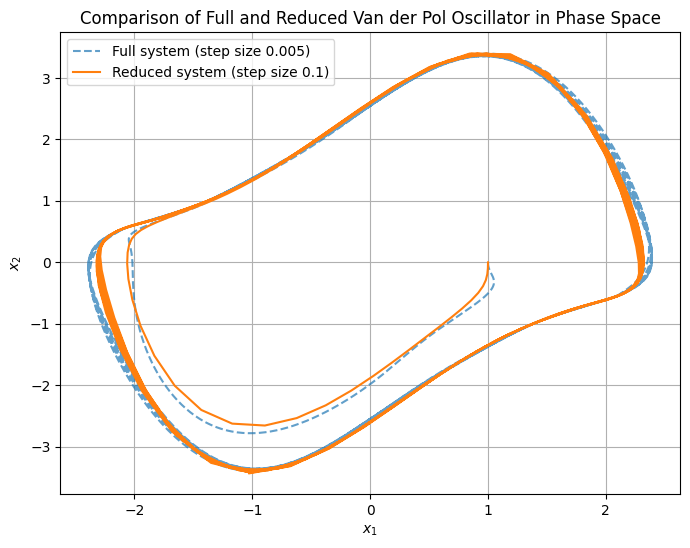

In [2]:
# Define the reduced Van der Pol oscillator (ignoring x3)
def reduced_van_der_pol(t, X):
    x1, x2 = X
    u_1, u_2 = control_input(t)
    dx1 = x2 + d1 * u_1  # Removed epsilon_1 * x3
    dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + d2 * u_2  # Removed epsilon_3 * x3
    return np.array([dx1, dx2])

# RK4 integration for the reduced system
def rk4_integrate_reduced(f, X0, t_span, step_size):
    t_values = np.arange(t_span[0], t_span[1], step_size)
    X_values = np.zeros((len(t_values), len(X0)))
    
    X = np.array(X0)
    for i, t in enumerate(t_values):
        X_values[i] = X
        
        k1 = step_size * f(t, X)
        k2 = step_size * f(t + step_size / 2, X + k1 / 2)
        k3 = step_size * f(t + step_size / 2, X + k2 / 2)
        k4 = step_size * f(t + step_size, X + k3)
        
        X += (k1 + 2 * k2 + 2 * k3 + k4) / 6  # RK4 update rule

    return t_values, X_values

# Initial conditions (only x1 and x2)
X0_reduced = [1.0, 0.0]
new_step_size = 0.1  # Choose a new step size

# Integrate the reduced system
t_vals_reduced, X_vals_reduced = rk4_integrate_reduced(reduced_van_der_pol, X0_reduced, t_span, new_step_size)

# Extract solutions
x1_reduced, x2_reduced = X_vals_reduced[:, 0], X_vals_reduced[:, 1]

# Plot comparison of full and reduced system
plt.figure(figsize=(8, 6))

# Plot the full system's trajectory (from the first cell)
plt.plot(x1, x2, label=f"Full system (step size {step_size})", linestyle='dashed', alpha=0.7)

# Plot the reduced system's trajectory
plt.plot(x1_reduced, x2_reduced, label=f"Reduced system (step size {new_step_size})", linestyle='solid')

# Plot settings
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Comparison of Full and Reduced Van der Pol Oscillator in Phase Space")
plt.legend()
plt.grid()
plt.show()



Now moving towards the MPC setting: Create and visualize a simple trajectory that we want to track

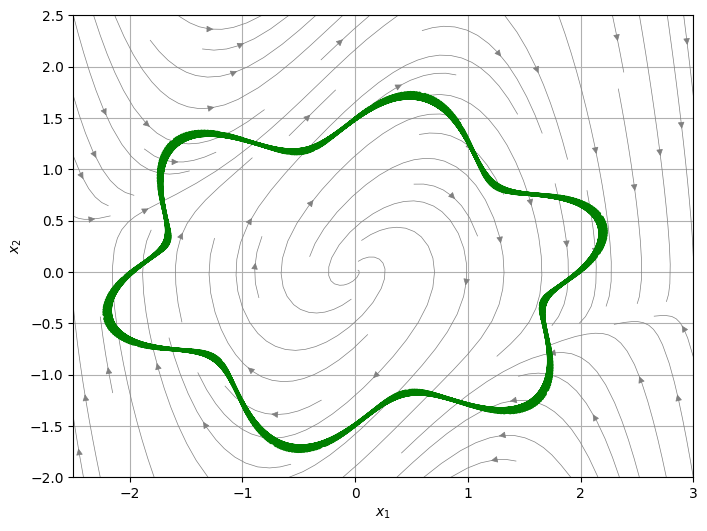

In [3]:
from van_der_pol.plotting_utils import plot_phase_space

def Phi_t(t):
    omega_1 = 2  # Base ellipse frequency
    alpha_1 = 2  # Major axis length
    alpha_2 = 1.5  # Minor axis length
    
    beta = 0.3  # Oscillation magnitude
    nu = 6 * omega_1  # Frequency of normal oscillation
    
    # Base ellipse
    x1 = alpha_1 * np.sin(omega_1 * t)
    x2 = alpha_2 * np.cos(omega_1 * t)
    
    # Tangent vector
    Tx = alpha_1 * omega_1 * np.cos(omega_1 * t)
    Ty = -alpha_2 * omega_1 * np.sin(omega_1 * t)
    
    # Normal vector (rotated tangent)
    Nx = alpha_2 * omega_1 * np.sin(omega_1 * t)
    Ny = alpha_1 * omega_1 * np.cos(omega_1 * t)
    
    # Normalize the normal vector
    norm = np.sqrt(Nx**2 + Ny**2)
    Nx /= norm
    Ny /= norm
    
    # Add oscillation in the normal direction
    x1_perturbed = x1 + beta * Nx * np.sin(nu * t)
    x2_perturbed = x2 + beta * Ny * np.sin(nu * t)
    
    return x1_perturbed, x2_perturbed


plot_phase_space(Phi_t)

Next, we compare the behaviour of the following MPCs. We always integrate with ERK and not IRk despite the stiff dynamics as we did not observe a big difference between the integration schemes in this example.

0) Baseline MPC: Exact model with a small step size of 0.005 and a long horizon.

1) Myopic MPC with exact-model and step size of 0.005. Has the same number of stages as 5). The MPC does not solve the task reliably.

2) Exact model with twice the step size as the baseline and the same time lookahead distance. Applied at a lower frequency corresponding to the larger step size. Also does not solve the task reliably.

3) Approximate model only. The model error prevents from accurate tracking. 

4) Exact model with exponentially increasing step sizes as in 6). The MPC performs decent, but has higher costs than 6) and also higher computation times. Likely this is due to the full model beeing integrated at too large step sizes. 

5) Only model switching without step size increase. Solves the task, but only small reduction in computation time.

6) Mixed model MPC, same time lookahead as 0) but with less stages and an exponential increase in step size. Note that we had to keep the step size increase moderate in this example as too large discretization steps can cause problems with (skipping) the constraints. The exact model is integrated with a small initial step size of 0.005. We switch to the approximate model of the slow dynamics in the middle of the horizon. We observe a minimal cost increase compared to 0), improved costs regarding 4) and lower computation times than both 0) and 4) and 5).



In [4]:
from van_der_pol.Van_der_pol_MPC import VanDerPolMPC, VanDerPolMPCOptions
from copy import deepcopy
from van_der_pol.utils import simulate_closed_loop
from utils_shared import compute_exponential_step_sizes
import gc
import shutil

# for plotting
latexify=True
save=True

# Parameters for experiment
t0 = 0.0
x01, x02 = Phi_t(t=t0) # Set initial state on the trajectory
x03 = 0.0
x0 = np.vstack((x01, x02, x03))

# collect mean costs and solve times
mean_costs = []
mean_solve_times = []
mean_solve_time_per_iter = []

mpc_opts_base = VanDerPolMPCOptions(
    # dynamics
    mu=mu,
    epsilon_1=epsilon_1,
    epsilon_2=epsilon_2,
    epsilon_3=epsilon_3,
    epsilon_4=epsilon_4,
    d1=d1,
    d2=d2,
    d3=d3,

    # Define two ellipses to avoid
    ellipse_centers=np.array([
        [1.9, -0.4],   # Center of first ellipse
        [1.4, -0.4],   # Center of second ellipse
        [2.4, -0.4]   # Center of third ellipse
    ]),
    ellipse_half_axes=np.array([
        [0.6, 0.2],    # Half-axis lengths (a, b) for first ellipse
        [0.2, 0.5],    # Half-axis lengths (a, b) for second ellipse
        [0.2, 0.5],    # Half-axis lengths (a, b) for third ellipse
    ])
)

### Create Simulator, model integrated with small step size and IRK treated as ground truth ###
dt_sim = 0.0025
mpc_opts_sim_solver = deepcopy(mpc_opts_base)
mpc_opts_sim_solver.N = 1
mpc_opts_sim_solver.step_size_list = [dt_sim]
mpc_opts_sim_solver.switch_stage = 2
mpc_opts_sim_solver.integrator_type = "IRK"
mpc_sim_solver = VanDerPolMPC(mpc_opts_sim_solver, Phi_t)
sim_solver = mpc_sim_solver.acados_sim_solver_3d

# Simulation parameter
duration = np.pi # track path and return to start position

### Baseline MPC ###
mpc_initial_dt = 0.005
control_step = int(mpc_initial_dt/dt_sim)
mpc_opts_baseline = deepcopy(mpc_opts_base)
N = 200
mpc_opts_baseline.N = N
mpc_opts_baseline.step_size_list = [mpc_initial_dt] * N
mpc_opts_baseline.switch_stage = N+1 # no switching, use exact model
mpc_opts_baseline.integrator_type = "ERK"
mpc_baseline = VanDerPolMPC(mpc_opts_baseline, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs, solve_times, SQP_iters = simulate_closed_loop(
    x0, mpc_baseline, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=control_step)
print("Baseline mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_baseline, closed_loop_traj=x_traj, number=0, latexify=latexify, save=save)
mean_costs.append(np.mean(costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_baseline
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

### 1) Myopic MPC with exact model ###
mpc_opts_1 = deepcopy(mpc_opts_base)
N = 150
mpc_opts_1.N = N
mpc_opts_1.step_size_list = [mpc_initial_dt] * N
mpc_opts_1.switch_stage = N+1 # no switching, usage of exact model
mpc_opts_1.integrator_type = "ERK"
mpc_1 = VanDerPolMPC(mpc_opts_1, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs, solve_times, SQP_iters = simulate_closed_loop(
    x0, mpc_1, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=control_step)
print("1) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_1, closed_loop_traj=x_traj, number=1, latexify=latexify, legend=True, save=save)
mean_costs.append(np.mean(costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_1
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)


### 2) Exact model with larger step size but same lookahead as baseline ###
mpc_opts_2 = deepcopy(mpc_opts_base)
N = 100
mpc_opts_2.N = N
mpc_opts_2.step_size_list = [2*mpc_initial_dt] * N
mpc_opts_2.switch_stage = N+1 # no switching, usage of exact model
mpc_opts_2.integrator_type = "ERK"
mpc_2 = VanDerPolMPC(mpc_opts_2, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs, solve_times, SQP_iters = simulate_closed_loop(
    x0, mpc_2, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=2*control_step)
print("2) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_2, closed_loop_traj=x_traj, number=2, latexify=latexify, save=save)
mean_costs.append(np.mean(costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_2
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

### 3) Approximate model only ### 
mpc_opts_3 = deepcopy(mpc_opts_base)
N = 200
mpc_opts_3.N = N
mpc_opts_3.step_size_list = [mpc_initial_dt] * N
mpc_opts_3.switch_stage = 0 #  use approximate model from stage 1 on
mpc_opts_3.integrator_type = "ERK"
mpc_3 = VanDerPolMPC(mpc_opts_3, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs, solve_times, SQP_iters = simulate_closed_loop(
    x0, mpc_3, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=control_step)
print("3) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_3, closed_loop_traj=x_traj, number=3, latexify=latexify, save=save)
mean_costs.append(np.mean(costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_3
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

### 4) Exact model with exponentially increasing step size, same time lookahead as baseline ###
mpc_opts_4 = deepcopy(mpc_opts_base)
N = 150 # Needsd to be chosen reasonable in this application, otherwhise too large step sizes can cause problems with integration and the constraints
mpc_opts_4.N = N
mpc_opts_4.step_size_list = compute_exponential_step_sizes(mpc_initial_dt, 200*mpc_initial_dt, N)
mpc_opts_4.integrator_type = "ERK"
mpc_opts_4.switch_stage = N+1 # suse exact model only
mpc_4 = VanDerPolMPC(mpc_opts_4, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs, solve_times, SQP_iters = simulate_closed_loop(
    x0, mpc_4, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=control_step)
print("4) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_4, closed_loop_traj=x_traj, number=4, latexify=latexify, save=save)
mean_costs.append(np.mean(costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_4
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

### 5) Only model switching, same step sizes as baseline ###
mpc_opts_5 = deepcopy(mpc_opts_base)
N = 200
mpc_opts_5.N = N
mpc_opts_5.step_size_list = [mpc_initial_dt] * N
mpc_opts_5.integrator_type = "ERK"
mpc_opts_5.switch_stage = 75 
mpc_5 = VanDerPolMPC(mpc_opts_5, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs, solve_times, SQP_iters = simulate_closed_loop(
    x0, mpc_5, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=control_step)
print("5) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_5, closed_loop_traj=x_traj, number=5, latexify=latexify, save=save)
mean_costs.append(np.mean(costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_5
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

### 6) Mixed model MPC with exponentially increasing step sizes ###
mpc_opts_6 = deepcopy(mpc_opts_base)
N = 150
mpc_opts_6.N = N
mpc_opts_6.step_size_list = compute_exponential_step_sizes(mpc_initial_dt, 200*mpc_initial_dt, N)
mpc_opts_6.integrator_type = "ERK"
mpc_opts_6.switch_stage = 75
mpc_6 = VanDerPolMPC(mpc_opts_6, Phi_t)

# Run closed-loop simulation
x_traj, u_traj, costs, solve_times, SQP_iters = simulate_closed_loop(
    x0, mpc_6, duration, sigma_noise=0.0, 
    sim_solver=sim_solver, control_step=control_step)
print("6) mean costs:", np.mean(costs))
plot_phase_space(Phi_t, mpc_6, closed_loop_traj=x_traj, number=6, latexify=latexify, save=save)
mean_costs.append(np.mean(costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_6
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_vdp_3d_1749152198291.so
rm -f vdp_3d_1749152198291_constraints/vdp_3d_1749152198291_constr_h_fun_jac_uxt_zt.o vdp_3d_1749152198291_constraints/vdp_3d_1749152198291_constr_h_fun.o vdp_3d_1749152198291_constraints/vdp_3d_1749152198291_constr_h_e_fun_jac_uxt_zt.o vdp_3d_1749152198291_constraints/vdp_3d_1749152198291_constr_h_e_fun.o vdp_3d_1749152198291_cost/vdp_3d_1749152198291_cost_y_0_fun.o vdp_3d_1749152198291_cost/vd

/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/fading_fidelity_MPC_repo_submission/src/van_der_pol/Van_der_pol_MPC.py:346: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if stage is not 0 and stage == self.opts.switch_stage: # 0 stage means only 2d model and no switch
/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/fading_fidelity_MPC_repo_submission/src/van_der_pol/Van_der_pol_MPC.py:346: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if stage is not 0 and stage == self.opts.switch_stage: # 0 stage means only 2d model and no switch


KeyboardInterrupt: 

Run the following cell to safe/load a results file.

In [ ]:
# save results or load them

import os
import pickle
from utils_shared import get_dir

data_dir = get_dir("data")
results_file = data_dir / "van_der_pol/vdp_results.pkl" 
# Note that the safed results file is a rerun of the results included in the thesis.
# This is as this the original results were not yet saved, but only figures and tables created based on it.
# However the result file is completely equivalent: same closed-loop cost,
# but naturally a minimal deviation in solve times, as solver timings show
# some small variance. I included this results file to show the timings on
# my machine.

if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        data = pickle.load(f)
    mean_costs = data['mean_costs']
    mean_solve_times = data['mean_solve_times']
    mean_solve_time_per_iter = data['mean_solve_time_per_iter']
else:
    # (Here assume mean_costs, mean_solve_times, mean_solve_time_per_iter are just computed)
    data = {
        'mean_costs': mean_costs,
        'mean_solve_times': mean_solve_times,
        'mean_solve_time_per_iter': mean_solve_time_per_iter
    }
    os.makedirs(os.path.dirname(results_file), exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump(data, f)

Next, we create bar plots and a pareto frontier of the observed closed-loop costs, solve times and solve times per SQP iteration. 

In [ ]:
# Plotting options for the following plots
latexify=True
save=True

In [ ]:
print(mean_costs)
print(mean_solve_times)
print(mean_solve_time_per_iter)

[0.48103027394993975, 5.133441330704636, 2.913615243897405, 1.2997681891173023, 0.6461236803490118, 0.5089309785054064, 0.5013167779505855]
[0.016011867834394903, 0.0065419060509554145, 0.006807012738853502, 0.01332583439490446, 0.0135646050955414, 0.017360861464968153, 0.009834563694267516]
[0.0025368345488043184, 0.0015297538710330686, 0.0011414980349063741, 0.0017704710272304683, 0.0016621969815060096, 0.0019794754313711797, 0.001473929426791136]


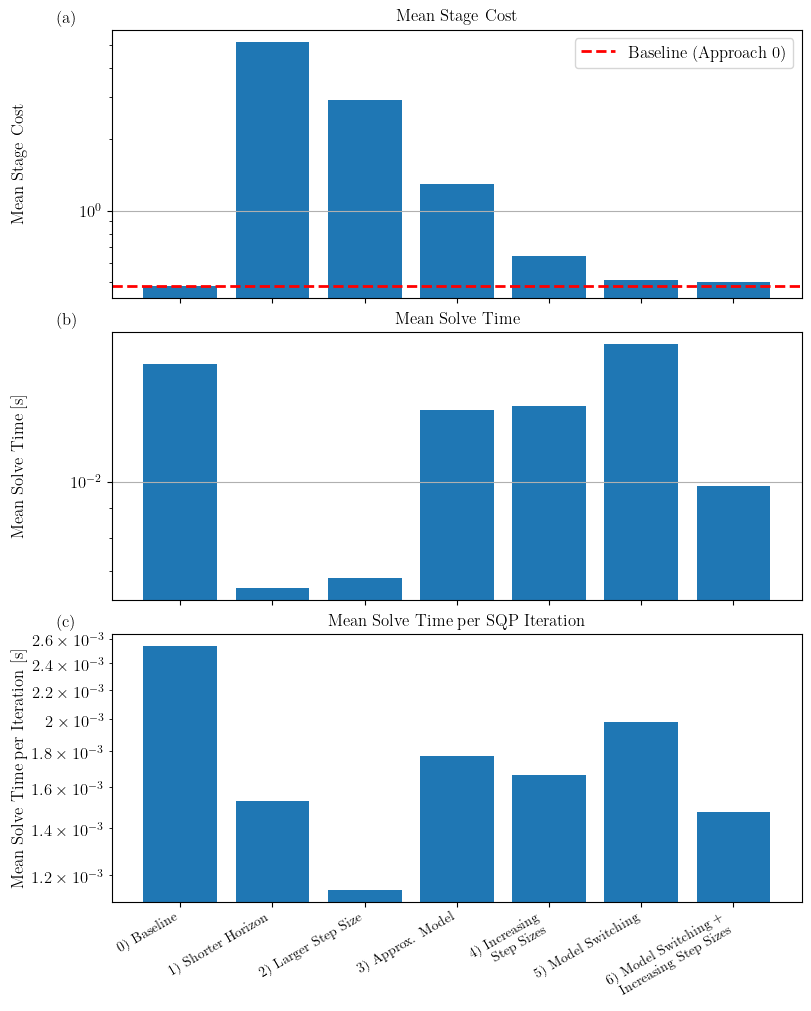

In [ ]:
import matplotlib.pyplot as plt
from acados_template import latexify_plot
from plotting_utils_shared import barplot

# Data: mean_costs, mean_solve_times, mean_solve_times_per_iter should be defined already
approach_labels = [
    '0) Baseline',
    '1) Shorter Horizon',
    '2) Larger Step Size',
    '3) Approx. Model',
    '4) Increasing\nStep Sizes',
    '5) Model Switching',
    '6) Model Switching +\nIncreasing Step Sizes'
]


barplot(
    approach_labels,
    mean_costs,
    mean_solve_times,
    mean_solve_time_per_iter,
    subpath="van_der_pol/vdp_barplot.pgf",
    latexify=latexify,
    save=save,
    figsize=(8, 10),
    fontsize=12,
)

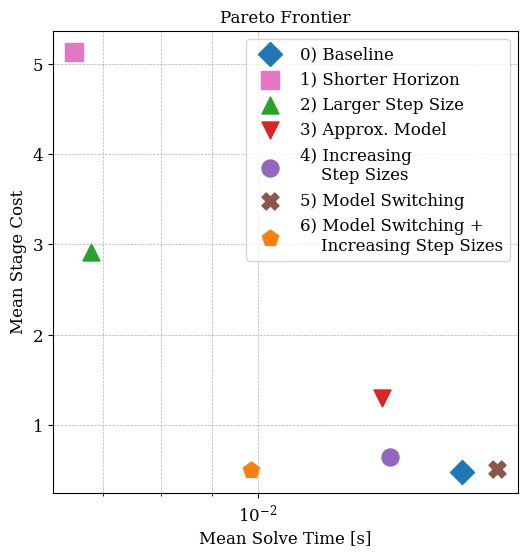

In [ ]:
import matplotlib.pyplot as plt
from plotting_utils_shared import pareto_frontier

# distinct symbols per approach
markers = ['D', 's', '^', 'v', 'o', 'X', 'p']

# NEW: marker sizes per approach (indexed same as markers)
marker_sizes = [150, 150, 150, 150, 150, 150, 150]  # customize these

approach_labels = [
    '0) Baseline',
    '1) Shorter Horizon',
    '2) Larger Step Size',
    '3) Approx. Model',
    '4) Increasing\n    Step Sizes',
    '5) Model Switching',
    '6) Model Switching +\n    Increasing Step Sizes'
]

pareto_frontier(
    mean_solve_times,
    mean_costs,
    approach_labels,
    markers,
    marker_sizes,
    subpath="van_der_pol/pareto_front_vdp.pdf",
    latexify=latexify,
    save=save,
    figsize=(6, 6),
    fontsize=12,
    x_lim=None,
    x_nonlog=False,
    y_nonlog=True
)